# Лабораторная работа 2. Визуализация градиентного спуска. Ландшафты потерь. Оптимайзеры.



In [10]:
# готовим функцию для красивой отрисовки градиента
# ФУНКЦИЯ ДВУХМЕРНОЙ ОТРИСОВКИ

import numpy as np
import matplotlib.pyplot as plt

def show_contours(objective,
                  x_lims=[-200.0, 202.0],
                  y_lims=[-200.0, 202.0],
                  x_ticks=100,
                  y_ticks=100):
    x_step = (x_lims[1] - x_lims[0]) / x_ticks
    y_step = (y_lims[1] - y_lims[0]) / y_ticks
    X, Y = np.mgrid[x_lims[0]:x_lims[1]:x_step, y_lims[0]:y_lims[1]:y_step]
    res = []
    for x_index in range(X.shape[0]):
        res.append([])
        for y_index in range(X.shape[1]):
            x_val = X[x_index, y_index]
            y_val = Y[x_index, y_index]
            res[-1].append(objective(np.array([[x_val, y_val]]).T))
    res = np.array(res)
    plt.figure(figsize=(7,7))
    plt.contour(X, Y, res, 100)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

In [11]:
# расcчитаем градиентный спуск для фунции для 10 cумма(x^2), x = тензор 1 на 2. Инициализирован значением 8
#  f(x1, x2) = 10(x1^2 + x2^2) - функция двух переменных - параболоид
import torch

# тензор
x = torch.tensor(
    [200.,200.], requires_grad=True)

# сюда будем складывать значения тензора x при каждом шаге градиентного спуска
var_history = []

# сюда будем складывать значения функции при каждом шаге градиентного спуска
fn_history = []

# определяем функцию.
def function_parabola(variable):
    return 10 * (variable ** 2).sum()

# считаем шаг градиентного спуска
lr = 0.01
def make_gradient_step(function, variable):
    function_result = function(variable)
    function_result.backward()
    variable.data -= lr * variable.grad
    variable.grad.zero_()

# реализуем градиентный спуск, думаем, что за 500 шагов справимся, и найдем минимум функции.
for i in range(500):
    var_history.append(x.data.cpu().numpy().copy())
    fn_history.append(function_parabola(x).data.cpu().numpy().copy())
    make_gradient_step(function_parabola, x)

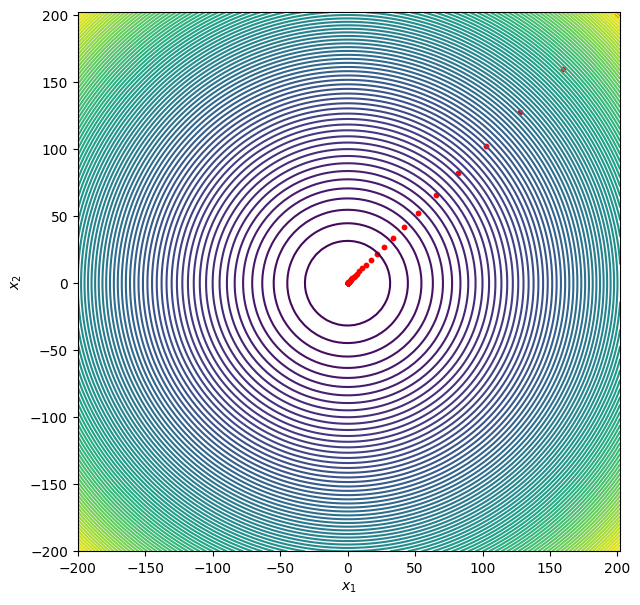

In [12]:
show_contours(function_parabola)
plt.scatter(np.array(var_history)[:,0], np.array(var_history)[:,1], s=10, c='r');

## Задание 1. Сделайте трехмерную визуализацию сходимости градиентного спуска. Нарисуйте поверхность функции двух переменных для которой осуществлялся поиск минимума методом градиентного спуска. Отдельными точками другого цвета изобразите позиции которые рассматривались на каждом шаге градиентного спуска.

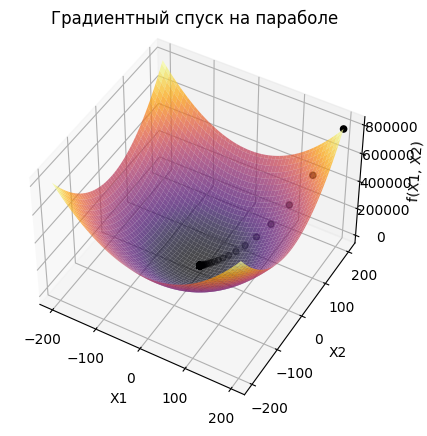

In [13]:
from mpl_toolkits.mplot3d import Axes3D

# Подготовка данных для 3D визуализации
x1 = np.linspace(-200, 200, 100)
x2 = np.linspace(-200, 200, 100)
X1, X2 = np.meshgrid(x1, x2)
Z = 10 * (X1**2 + X2**2)

# Визуализация функции
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, Z, cmap='inferno', alpha=0.7)
ax.view_init(45)


#Траектория градиентного спуска
ax.scatter(np.array(var_history)[:,0], np.array(var_history)[:,1], np.array(fn_history), color='black');

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('f(X1, X2)')
ax.set_title('Градиентный спуск на параболе')

plt.show()

## Задание 2. Для своего кода лабораторной работы №1 примените три разных оптимайзера. Постройте графики зависимости величины функции потерь от номера эпохи для всех трех оптимайзеров на одном графике сначала для обучающей выборки, потом для тестовой.

In [1]:
# ваш код здесь
# Импорт библиотек

import random
import numpy as np
import matplotlib.pyplot as plt
import torch

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
# будем использовать встроенные датасеты торча.
# полный список - тут https://pytorch.org/vision/stable/datasets.html

# Используемый датасет: https://cs.stanford.edu/~acoates/stl10/
import torchvision.datasets

Загрузчик данных (DataLoader) в контексте машинного обучения и глубокого обучения служит для упрощения и оптимизации процесса работы с данными. Вот основные причины, зачем он нужен:

1. Обработка мини-батчей: Загрузчик данных автоматически делит набор данных на мини-батчи, что позволяет модели обновлять веса более эффективно, вместо работы с одним элементом за раз.
2. Перемешивание данных: Загрузчик данных может случайным образом перемешивать данные в каждом эпопе, что помогает улучшить обобщающую способность модели и избежать переобучения.
3. Управление многопоточностью: DataLoader может использовать несколько потоков для загрузки данных, что значительно ускоряет процесс, особенно при работе с большими датасетами.
4. Гибкость в трансформациях: Можно легко применять различные трансформации и предобработки к данным на лету (например, нормализация, аугментация и т. д.) при каждой загрузке мини-батча.
5. Поддержка различных форматов данных: Загрузчик данных можно настроить для работы с различными формами хранения (файлы, базы данных и т.д.), обеспечивая единый интерфейс для доступа к данным.

In [3]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import STL10

# Определяем преобразования данных
transform = transforms.Compose([
    transforms.Resize((96, 96)),  # Изменение размера изображений до 96x96 пикселей
    transforms.ToTensor(),        # Конвертация изображений в тензоры
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализация
])

# Загружаем набор данных
stl10_train = STL10(root='./data', split='train', transform=transform, download=True)
stl10_test = STL10(root='./data', split='test', transform=transform, download=True)

100%|██████████| 2640397119/2640397119 [09:36<00:00, 4582038.63it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Формируем x_train и y_train
x_train = torch.stack([stl10_train[i][0] for i in range(len(stl10_train))])  # Объединяем изображения в один тензор
y_train = torch.tensor([stl10_train[i][1] for i in range(len(stl10_train))])  # Объединяем метки в один тензор

# Формируем x_test и y_test
x_test = torch.stack([stl10_test[i][0] for i in range(len(stl10_test))])  # Объединяем тестовые изображения в один тензор
y_test = torch.tensor([stl10_test[i][1] for i in range(len(stl10_test))])  # Объединяем тестовые метки в один тензор

# Выводим размеры полученных тензоров
print(f'x_train shape: {x_train.shape}')  # Размеры обучающего набора
print(f'y_train shape: {y_train.shape}')  # Размеры меток обучающего набора
print(f'x_test shape: {x_test.shape}')    # Размеры тестового набора
print(f'y_test shape: {y_test.shape}')    # Размеры меток тестового набора

x_train shape: torch.Size([5000, 3, 96, 96])
y_train shape: torch.Size([5000])
x_test shape: torch.Size([8000, 3, 96, 96])
y_test shape: torch.Size([8000])


In [5]:
import torch

class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        # на вход 3 канала
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        # Изменяем размер входа на 7744 для первого полносвязного слоя
        # первый свёрточный слой - 96 * 96 ... (96 - 5 + 4*1) + 1  = 96
        # второй слой "self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)' пуллинг 48*48
        # второй свёрточный слов вход - 6 каналов, выход 16 каналов, размер сетки 5, добавочные пиксели 0
        # (48 - 5 + 0*1) + 1 = 44
        # второй слой пуллинга - 22 *22, 16 каналов
        self.fc1   = torch.nn.Linear(16 * 22 * 22, 120)
        self.act3  = torch.nn.Tanh()

        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()

        self.fc3   = torch.nn.Linear(84, 10)  # 10 классов

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.reshape(x.size(0), -1)

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = "cpu"
#  доступна ли CUDA
# CUDA позволяет использовать графические процессоры (GPU) для ускорения вычислений в PyTorch
# если доступно используем GPU (первый доступный - 'cuda:0'), иначе CPU

# Инициализация модели
lenet5 = LeNet5().to(device)


In [6]:
# в качестве функции потерь будем использовать CrossEntropyLoss()
loss = torch.nn.CrossEntropyLoss()

# в качестве оптимайзера, который будет вычислять градиенты и минимизировать функцию потерь, будем использовать Adam (Адаптивная оценка момента)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

Целый день меняла функцию модели, чтобы повысить её точность, достигла 1 на тренировочной выборке и 0,54 на тестовой выборке, но часто среда выполнения прерывается из-за исчерпывания ОЗУ(((
  
Поэтому задание выполнила на исходном коде первой лабораторной работы с уменьшенным количеством эпох

Training with SGD optimizer
SGD training completed
Training with Adam optimizer
Adam training completed
Training with RMSprop optimizer
RMSprop training completed


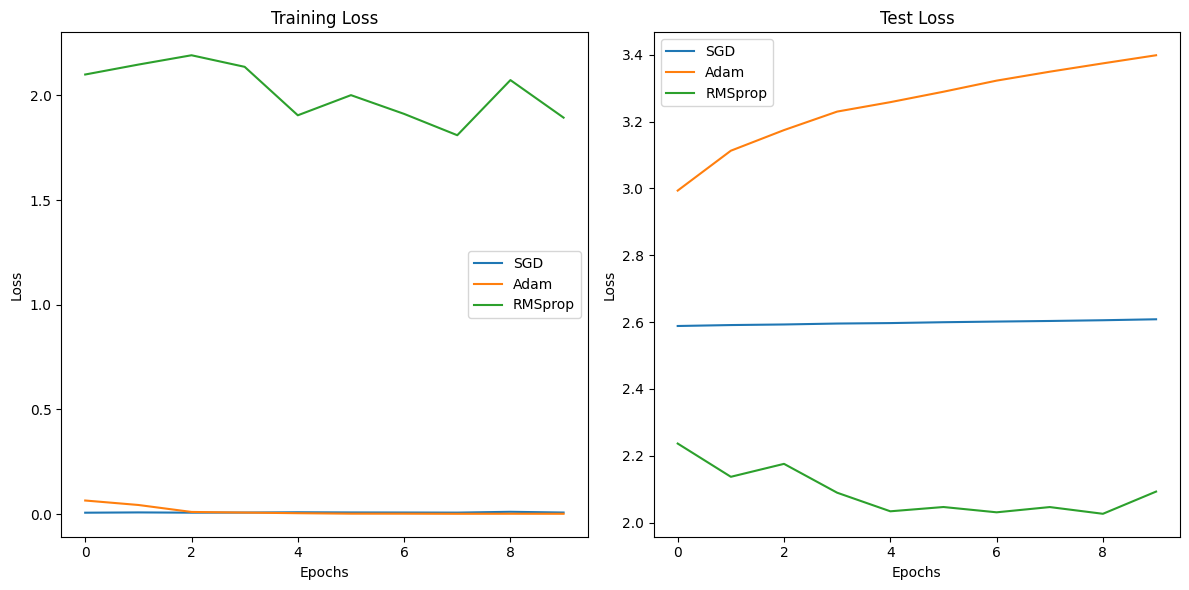

In [9]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Оптимизаторы
optimizers = {
    'SGD': optim.SGD(lenet5.parameters(), lr=0.01),
    'Adam': optim.Adam(lenet5.parameters(), lr=0.001),
    'RMSprop': optim.RMSprop(lenet5.parameters(), lr=0.01)
}

# Хранилища для истории потерь
train_loss_histories = {name: [] for name in optimizers.keys()}
test_loss_histories = {name: [] for name in optimizers.keys()}

# Количество эпох
epochs = 10
batch_size = 100

# Основной цикл для каждого оптимизатора
for optimizer_name, optimizer in optimizers.items():
    print(f"Training with {optimizer_name} optimizer")

    for epoch in range(epochs):
        # Перемешиваем порядок обучения
        order = np.random.permutation(len(x_train))

        for start_index in range(0, len(x_train), batch_size):
            # Обнуляем градиенты
            optimizer.zero_grad()

            # Получаем индексы для текущей пачки
            batch_indexes = order[start_index:start_index + batch_size]

            # Берём текущий батч данных
            x_batch = x_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            # Делаем предсказание
            preds = lenet5(x_batch)

            # Вычисляем значение потерь
            loss_value = loss(preds, y_batch)

            # Получаем градиенты и выполняем оптимизацию
            loss_value.backward()
            optimizer.step()

        # Сохраняем данные о обучении
        train_loss_histories[optimizer_name].append(loss_value.item())

        # Проверяем модель на тестовых данных
        with torch.no_grad():  # Отключаем вычисление градиентов
            test_preds = lenet5(x_test)
            test_loss = loss(test_preds, y_test).item()
            test_loss_histories[optimizer_name].append(test_loss)

    print(f"{optimizer_name} training completed")

# Построение графиков
plt.figure(figsize=(12, 6))

# График для обучающей выборки
plt.subplot(1, 2, 1)
for optimizer_name in optimizers.keys():
    plt.plot(train_loss_histories[optimizer_name], label=optimizer_name)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График для тестовой выборки
plt.subplot(1, 2, 2)
for optimizer_name in optimizers.keys():
    plt.plot(test_loss_histories[optimizer_name], label=optimizer_name)
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Задание 3. Изучите статью https://habr.com/ru/companies/skillfactory/articles/536606/. Попробуйте воспроизвести ее результаты в своем коде. Если не получится сделать анимацию, можно те же графики оставить статическими.

In [6]:
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


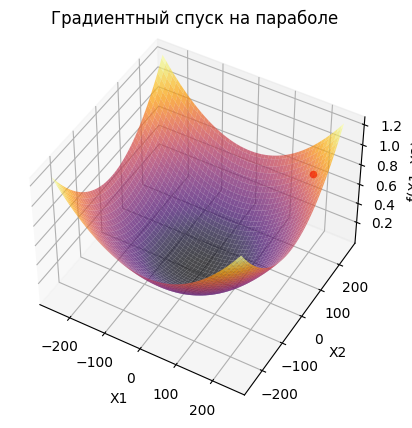

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

# Инициализация тензора
x = torch.tensor([200., 200.], requires_grad=True)

# Списки для хранения истории переменных и значений функции потерь
var_history = []
fn_history = []

# Определение функции параболоида
def function_parabola(variable):
    return 10 * (variable ** 2).sum()

# Шаг градиентного спуска
lr = 0.01
def make_gradient_step(function, variable):
    function_result = function(variable)
    function_result.backward()
    with torch.no_grad():
        variable -= lr * variable.grad  # Обновляем параметры
        variable.grad.zero_()  # Обнуляем градиенты

# Градиентный спуск на 500 итераций
for i in range(500):
    var_history.append(x.data.numpy().copy())  # Сохраняем историю переменных
    fn_history.append(function_parabola(x).data.numpy().copy())  # Сохраняем значения функции
    make_gradient_step(function_parabola, x)

# Преобразуем историю переменных в numpy массив
var_history = np.array(var_history)
fn_history = np.array(fn_history)

# Подготовка данных для 3D визуализации
x1_range = np.linspace(-250, 250, 100)
x2_range = np.linspace(-250, 250, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)
Z = 10 * (X1**2 + X2**2)  # Значения функции параболоида

# Создаем фигуру и оси для 3D графика
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Визуализация поверхности параболоида
ax.plot_surface(X1, X2, Z, cmap='inferno', alpha=0.7)

# Настройка осей
ax.view_init(45)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('f(X1, X2)')
ax.set_title('Градиентный спуск на параболе')

# Добавляем точку, которая будет обновляться
point = ax.scatter([], [], [], color='red')

# Функция для обновления анимации
def update(frame):
    point._offsets3d = (var_history[frame, 0:1], var_history[frame, 1:2], fn_history[frame:frame+1])
    return point,

# Создание анимации
ani = FuncAnimation(fig, update, frames=len(var_history), interval=50)

# Сохраняем анимацию в видео формате mp4
ani.save('gradient_descent.mp4', writer='ffmpeg', fps=30)

# Воспроизводим видео в Google Colab
from IPython.display import HTML
from base64 import b64encode

video = open('gradient_descent.mp4', 'rb').read()
video_encoded = b64encode(video).decode()

HTML(f'''
<video width="640" height="480" controls>
  <source src="data:video/mp4;base64,{video_encoded}" type="video/mp4">
</video>
''')


## Задание 4. В коде, полученном после выполнения задания 3, релизуйте по формулам один из оптимайзеров. Как изменится визуализация поиска минимума из тех же трех точек?

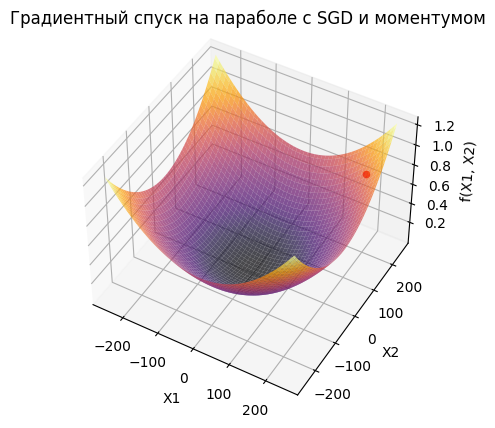

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

# Инициализация тензора
x = torch.tensor([200., 200.], requires_grad=True)

# Списки для хранения истории переменных и значений функции потерь
var_history = []
fn_history = []

# Определение функции параболоида
def function_parabola(variable):
    return 10 * (variable ** 2).sum()

# Параметры SGD с моментумом
lr = 0.01
momentum = 0.9
velocity = torch.zeros_like(x)  # Инициализация скорости

# Шаг градиентного спуска с использованием SGD с моментумом
def make_gradient_step(function, variable):
    function_result = function(variable)
    function_result.backward()
    with torch.no_grad():
        # Обновление скорости
        velocity.copy_(momentum * velocity + lr * variable.grad)
        variable -= velocity  # Обновляем параметры
        variable.grad.zero_()  # Обнуляем градиенты

# Градиентный спуск на 500 итераций
for i in range(500):
    var_history.append(x.data.numpy().copy())  # Сохраняем историю переменных
    fn_history.append(function_parabola(x).data.numpy().copy())  # Сохраняем значения функции
    make_gradient_step(function_parabola, x)

# Преобразуем историю переменных в numpy массив
var_history = np.array(var_history)
fn_history = np.array(fn_history)

# Подготовка данных для 3D визуализации
x1_range = np.linspace(-250, 250, 100)
x2_range = np.linspace(-250, 250, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)
Z = 10 * (X1**2 + X2**2)  # Значения функции параболоида

# Создаем фигуру и оси для 3D графика
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Визуализация поверхности параболоида
ax.plot_surface(X1, X2, Z, cmap='inferno', alpha=0.7)

# Настройка осей
ax.view_init(45)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('f(X1, X2)')
ax.set_title('Градиентный спуск на параболе с SGD и моментумом')

# Добавляем точку, которая будет обновляться
point = ax.scatter([], [], [], color='red')

# Функция для обновления анимации
def update(frame):
    point._offsets3d = (var_history[frame, 0:1], var_history[frame, 1:2], fn_history[frame:frame+1])
    return point,

# Создание анимации
ani = FuncAnimation(fig, update, frames=len(var_history), interval=50)

# Сохраняем анимацию в видео формате mp4
ani.save('gradient_descent_sgd.mp4', writer='ffmpeg', fps=30)

# Воспроизводим видео в Google Colab
from IPython.display import HTML
from base64 import b64encode

video = open('gradient_descent_sgd.mp4', 'rb').read()
video_encoded = b64encode(video).decode()

HTML(f'''
<video width="640" height="480" controls>
  <source src="data:video/mp4;base64,{video_encoded}" type="video/mp4">
</video>
''')
